<a href="https://colab.research.google.com/github/exanode/Machine-Learning-Hackathons/blob/main/ocr_table_paddleocr_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PaddleOCR & Dependencies
!pip install "paddlepaddle" "paddleocr" "pdf2image" "opencv-python" "pandas" "numpy"
!apt-get install -y poppler-utils  # Required for pdf2image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 11.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=2266b9895a6f5d8a16ddfa7eff62e74c012215fe1521ecd536ff6807bd2163f8
  Stored in

In [2]:
import cv2
import numpy as np
import pandas as pd
from paddleocr import PaddleOCR
from pdf2image import convert_from_path
from PIL import Image
import os

# Step 1: Upload PDF Manually in Colab or Use Google Drive
from google.colab import files

uploaded = files.upload()  # Manually upload the PDF
pdf_file = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_file}")

output_csv_path = "/content/extracted_table.csv"  # Colab working directory

# Step 2: Convert PDF Page 2 to Image
images = convert_from_path(pdf_file, first_page=2, last_page=2)
image_path = "/content/page_2.png"
images[0].save(image_path, "PNG")

# Step 3: Load Image and Preprocess for Table Detection
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Step 4: Detect Table Structure using OpenCV
kernel = np.ones((2, 2), np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=1)

# Find contours & filter for the table
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
table_boxes = [cv2.boundingRect(c) for c in contours if cv2.boundingRect(c)[2] > 400 and cv2.boundingRect(c)[3] > 100]

# Select the largest detected table
table_boxes = sorted(table_boxes, key=lambda b: b[2] * b[3], reverse=True)
if len(table_boxes) > 0:
    x, y, w, h = table_boxes[0]  # Largest detected table
    table_region = image[y:y+h, x:x+w]
    cropped_table_path = "/content/cropped_table.png"
    cv2.imwrite(cropped_table_path, table_region)  # Save cropped table image

# Step 5: Extract Text from Only the Table Using PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")  # Use lightweight PaddleOCR instead of PP-Structure
result = ocr.ocr(cropped_table_path, cls=True)

# Step 6: Extract Text and Bounding Box Positions
table_data = []
for line in result[0]:
    [[x1, y1, x2, y2], text, confidence] = line[0], line[1][0], line[1][1]
    table_data.append([text, x1[0], y1[1], x2[0], y2[1], confidence])  # Extract numerical values from lists

# Step 7: Improved Sorting & Column Assignment
table_data = sorted(table_data, key=lambda b: (b[2], b[1]))  # Sort top to bottom, left to right

num_cols = 5  # Define expected number of columns
table_rows = []
current_row = [""] * num_cols  # Empty row template
prev_y = None
col_positions = []  # Store detected column positions

# STEP 1: Detect Columns Using ALL Rows Instead of Just the First Row
detected_columns = sorted(set(x1 for _, x1, _, _, _, _ in table_data))  # Get all unique X-coordinates

# If there are more detected columns than expected, group them
if len(detected_columns) > num_cols:
    col_positions = np.linspace(min(detected_columns), max(detected_columns), num_cols)
else:
    col_positions = detected_columns  # Use detected positions if they match num_cols

# STEP 2: Assign Text to the Correct Column
for text, bbox_x1, bbox_y1, bbox_x2, bbox_y2, conf in table_data:
    y1 = bbox_y1  # Y-position
    x1 = bbox_x1  # X-position

    # Find the closest column while ensuring it's inside the bounding box width
    col_index = min(range(len(col_positions)), key=lambda i: abs(col_positions[i] - x1))

    # Ensure text is not mistakenly pushed to an incorrect column by limiting X-distance
    if abs(col_positions[col_index] - x1) > 50:  # Set a threshold for column misalignment
        col_index = num_cols - 1  # Force it into the last column (where "VOL" belongs)

    # STEP 3: Merge Multi-Line Cells Correctly
    if prev_y is not None and abs(prev_y - y1) < 20:  # Small Y-difference → same row
        current_row[col_index] += " " + text
    else:
        # Store previous row before moving to new one
        if any(current_row):  # Only store non-empty rows
            table_rows.append(current_row)

        # Reset and start a new row
        current_row = [""] * num_cols
        current_row[col_index] = text

    prev_y = y1  # Update previous y-coordinate

# Store last row if not empty
if any(current_row):
    table_rows.append(current_row)

# Step 8: Remove Duplicate Header Rows
if len(table_rows) > 1 and table_rows[0] == table_rows[1]:
    table_rows.pop(0)

# Convert to DataFrame WITHOUT column numbers in the header
df = pd.DataFrame(table_rows)
df.to_csv("/content/fixed_table.csv", index=False, header=False)  # No column headers

# Step 9: Download the Extracted CSV File
files.download("/content/fixed_table.csv")

print('✅ Table extraction completed successfully. Download the CSV file from Colab.')


Saving App-2 AIP DGCAR change request V1.3 (002).pdf to App-2 AIP DGCAR change request V1.3 (002).pdf
Uploaded file: App-2 AIP DGCAR change request V1.3 (002).pdf
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:15<00:00, 247.64it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:18<00:00, 543.39it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:15<00:00, 140.66it/s]

[2025/03/04 13:50:00] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

[2025/03/04 13:50:03] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.7184767723083496
[2025/03/04 13:50:03] ppocr DEBUG: cls num  : 63, elapsed : 0.19826030731201172
[2025/03/04 13:50:10] ppocr DEBUG: rec_res num  : 63, elapsed : 6.873286247253418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Table extraction completed successfully. Download the CSV file from Colab.


In [4]:
# Install PaddleOCR & Dependencies
!pip install "paddlepaddle" "paddleocr" "pdf2image" "opencv-python" "pandas" "numpy"
!apt-get install -y poppler-utils  # Required for pdf2image

import cv2
import numpy as np
import pandas as pd
from paddleocr import PaddleOCR
from pdf2image import convert_from_path
from PIL import Image
import os

# Step 1: Upload PDF Manually in Colab
from google.colab import files
uploaded = files.upload()  # Manually upload the PDF
pdf_file = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_file}")

output_csv_path = "/content/extracted_table.csv"  # Colab working directory

# Step 2: Convert PDF Page 2 to Image (Keep in COLOR)
images = convert_from_path(pdf_file, first_page=2, last_page=2)
image_path = "/content/page_2.png"
images[0].save(image_path, "PNG")

# Step 3: Load Image WITHOUT Grayscale
image = cv2.imread(image_path)  # Read in color (BGR)

# Step 4: Detect Table Structure using OpenCV
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for thresholding
thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours & filter for the table
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
table_boxes = [cv2.boundingRect(c) for c in contours if cv2.boundingRect(c)[2] > 400 and cv2.boundingRect(c)[3] > 100]

# Select the largest detected table
table_boxes = sorted(table_boxes, key=lambda b: b[2] * b[3], reverse=True)
if len(table_boxes) > 0:
    x, y, w, h = table_boxes[0]  # Largest detected table
    table_region = image[y:y+h, x:x+w]  # Keep in COLOR
    cropped_table_path = "/content/cropped_table.png"
    cv2.imwrite(cropped_table_path, table_region)  # Save cropped table image

# Step 5: Extract Text from Only the Table Using PaddleOCR (Keep Color)
ocr = PaddleOCR(use_angle_cls=True, lang="en")  # Use lightweight PaddleOCR instead of PP-Structure
result = ocr.ocr(cropped_table_path, cls=True)

# Step 6: Extract Text, Bounding Box Positions & Color Information
def get_text_color(image, x1, y1, x2, y2):
    """Determines the dominant text color in a bounding box."""
    roi = image[y1:y2, x1:x2]  # Crop the region
    avg_color = np.mean(roi, axis=(0, 1))  # Compute average color (BGR)
    r, g, b = avg_color[2], avg_color[1], avg_color[0]  # Convert BGR to RGB

    # Define color thresholds
    if r > 150 and g < 100 and b < 100:  # Red text
        return "red"
    elif b > 150 and r < 100 and g < 100:  # Blue text
        return "blue"
    else:
        return "black"  # Assume black if not strongly red or blue

table_data = []
for line in result[0]:
    [[x1, y1, x2, y2], text, confidence] = line[0], line[1][0], line[1][1]
    text_color = get_text_color(table_region, int(x1[0]), int(y1[1]), int(x2[0]), int(y2[1]))
    table_data.append([text, x1[0], y1[1], x2[0], y2[1], confidence, text_color])  # Extract text & color

# Step 7: Improved Sorting & Column Assignment
table_data = sorted(table_data, key=lambda b: (b[2], b[1]))  # Sort top to bottom, left to right

num_cols = 7  # Define expected number of columns (added 2 new columns)
table_rows = []
current_row = [""] * num_cols  # Empty row template
prev_y = None
col_positions = []  # Store detected column positions

# Detect Columns Using ALL Rows Instead of Just the First Row
detected_columns = sorted(set(x1 for _, x1, _, _, _, _, _ in table_data))  # Get all unique X-coordinates

# If more detected columns than expected, group them
if len(detected_columns) > 5:
    col_positions = np.linspace(min(detected_columns), max(detected_columns), 5)
else:
    col_positions = detected_columns  # Use detected positions if they match 5 columns

# Assign Text to the Correct Column & Create New Columns
for text, bbox_x1, bbox_y1, bbox_x2, bbox_y2, conf, text_color in table_data:
    y1 = bbox_y1  # Y-position
    x1 = bbox_x1  # X-position

    # Find the closest column
    col_index = min(range(len(col_positions)), key=lambda i: abs(col_positions[i] - x1))

    # Ensure text stays within correct column boundaries
    if abs(col_positions[col_index] - x1) > 50:
        col_index = 4  # Force into last column if misaligned

    # Merge Multi-Line Cells Correctly
    if prev_y is not None and abs(prev_y - y1) < 20:  # Small Y-difference → same row
        current_row[col_index] += " " + text
    else:
        # Store previous row before moving to new one
        if any(current_row):  # Only store non-empty rows
            table_rows.append(current_row)

        # Reset and start a new row
        current_row = [""] * num_cols
        current_row[col_index] = text

    # **NEW: Assign Text to New Color-Based Columns (Only from Column 5)**
    if col_index == 4:  # Only filter from column 5
        if text_color in ["black", "blue"]:  # Column 6: Black + Blue Text
            current_row[5] += " " + text
        if text_color in ["black", "red"]:  # Column 7: Black + Red Text
            current_row[6] += " " + text

    prev_y = y1  # Update previous y-coordinate

# Store last row if not empty
if any(current_row):
    table_rows.append(current_row)

# Remove Duplicate Header Rows
if len(table_rows) > 1 and table_rows[0] == table_rows[1]:
    table_rows.pop(0)

# Define Column Headers
columns = ["Page (date)", "Section", "Subsection", "Paragraph", "Text of AIP Amendment", "Black/Blue Text", "Black/Red Text"]

# Convert to DataFrame & Save
df = pd.DataFrame(table_rows, columns=columns)
df.to_csv("/content/fixed_table_with_color.csv", index=False)

# Download CSV File
files.download("/content/fixed_table_with_color.csv")

print('✅ Table extraction with color filtering completed! Download the CSV file from Colab.')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Saving App-2 AIP DGCAR change request V1.3 (002).pdf to App-2 AIP DGCAR change request V1.3 (002) (2).pdf
Uploaded file: App-2 AIP DGCAR change request V1.3 (002) (2).pdf
[2025/03/04 14:01:40] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Table extraction with color filtering completed! Download the CSV file from Colab.


In [5]:
table_data

[['Section', 188.0, 6.0, 286.0, 33.0, 0.9996194839477539, 'black'],
 ['Page (date)', 14.0, 8.0, 158.0, 36.0, 0.9999071359634399, 'black'],
 ['Subsection', 317.0, 8.0, 458.0, 35.0, 0.9998699426651001, 'black'],
 ['Paragraph', 491.0, 8.0, 622.0, 36.0, 0.9858028888702393, 'black'],
 ['Text of AIP Amendment.',
  809.0,
  11.0,
  1104.0,
  33.0,
  0.9320123791694641,
  'black'],
 ['1.6', 311.0, 88.0, 359.0, 119.0, 0.9999076724052429, 'black'],
 ['1.2', 485.0, 88.0, 533.0, 119.0, 0.9998781085014343, 'black'],
 ['GEN 1.6', 14.0, 89.0, 118.0, 118.0, 0.994540274143219, 'black'],
 ['GEN', 188.0, 89.0, 247.0, 118.0, 0.9983800053596497, 'black'],
 ['Electronic copies of these documente',
  652.0,
  93.0,
  1118.0,
  116.0,
  0.999719500541687,
  'black'],
 ['(last line)', 490.0, 127.0, 606.0, 155.0, 0.9733690619468689, 'black'],
 ['legislations and regulations may can also be',
  656.0,
  129.0,
  1196.0,
  155.0,
  0.9888069033622742,
  'black'],
 ['obtained from:', 654.0, 166.0, 841.0, 193.0, 0.

In [7]:
# Install PaddleOCR & Dependencies
!pip install "paddlepaddle" "paddleocr" "pdf2image" "opencv-python" "pandas" "numpy"
!apt-get install -y poppler-utils  # Required for pdf2image

import cv2
import numpy as np
import pandas as pd
from paddleocr import PaddleOCR
from pdf2image import convert_from_path
from PIL import Image
import os

# Step 1: Upload PDF Manually in Colab
from google.colab import files
uploaded = files.upload()  # Manually upload the PDF
pdf_file = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_file}")

output_csv_path = "/content/extracted_table.csv"  # Colab working directory

# Step 2: Convert PDF Page 2 to Image (Keep in COLOR)
images = convert_from_path(pdf_file, first_page=2, last_page=2)
image_path = "/content/page_2.png"
images[0].save(image_path, "PNG")

# Step 3: Load Image WITHOUT Grayscale
image = cv2.imread(image_path)  # Read in color (BGR)

# Step 4: Detect Table Structure using OpenCV
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for thresholding
thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours & filter for the table
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
table_boxes = [cv2.boundingRect(c) for c in contours if cv2.boundingRect(c)[2] > 400 and cv2.boundingRect(c)[3] > 100]

# Select the largest detected table
table_boxes = sorted(table_boxes, key=lambda b: b[2] * b[3], reverse=True)
if len(table_boxes) > 0:
    x, y, w, h = table_boxes[0]  # Largest detected table
    table_region = image[y:y+h, x:x+w]  # Keep in COLOR
    cropped_table_path = "/content/cropped_table.png"
    cv2.imwrite(cropped_table_path, table_region)  # Save cropped table image

# Step 5: Extract Text from Only the Table Using PaddleOCR (Keep Color)
ocr = PaddleOCR(use_angle_cls=True, lang="en")  # Use lightweight PaddleOCR instead of PP-Structure
result = ocr.ocr(cropped_table_path, cls=True)

# Step 6: Improved Color Detection
def get_text_color(image, x1, y1, x2, y2):
    """Determines the dominant text color in a bounding box."""
    roi = image[max(0, y1):min(y2, image.shape[0]), max(0, x1):min(x2, image.shape[1])]  # Crop text area

    # Ensure we are only sampling the text, not too much background
    height, width, _ = roi.shape
    sample_size = max(1, width // 10)  # Sample multiple points from each text box

    # Collect multiple color samples instead of a single average
    sampled_pixels = roi[::sample_size, ::sample_size].reshape(-1, 3)  # Downsample the region
    avg_color = np.median(sampled_pixels, axis=0)  # Use median instead of mean
    r, g, b = avg_color[2], avg_color[1], avg_color[0]  # Convert BGR to RGB

    # Debugging: Print color values for testing
    print(f"Detected color (R,G,B): ({r:.0f}, {g:.0f}, {b:.0f}) at [{x1}, {y1}, {x2}, {y2}]")

    # Define color thresholds (Adjust these based on the actual image)
    if r > 120 and g < 100 and b < 100:  # Red Text
        return "red"
    elif b > 120 and r < 100 and g < 100:  # Blue Text
        return "blue"
    elif r > 80 and g > 80 and b > 80:  # Black/Dark Text
        return "black"
    else:
        return "unknown"  # Unknown/grayish text

table_data = []
for line in result[0]:
    [[x1, y1, x2, y2], text, confidence] = line[0], line[1][0], line[1][1]
    text_color = get_text_color(table_region, int(x1[0]), int(y1[1]), int(x2[0]), int(y2[1]))
    table_data.append([text, x1[0], y1[1], x2[0], y2[1], confidence, text_color])  # Extract text & color

# Step 7: Improved Sorting & Column Assignment
table_data = sorted(table_data, key=lambda b: (b[2], b[1]))  # Sort top to bottom, left to right

num_cols = 7  # Define expected number of columns (added 2 new columns)
table_rows = []
current_row = [""] * num_cols  # Empty row template
prev_y = None
col_positions = []  # Store detected column positions

# Detect Columns Using ALL Rows Instead of Just the First Row
detected_columns = sorted(set(x1 for _, x1, _, _, _, _, _ in table_data))  # Get all unique X-coordinates

# ✅ Fix: Ensure col_positions is never empty
if len(detected_columns) >= 5:
    col_positions = np.linspace(min(detected_columns), max(detected_columns), 5)
else:
    print("⚠ Warning: No valid column positions detected, using fallback values!")
    col_positions = np.linspace(100, 1000, 5)  # Default fallback values

print(f"📌 Detected Column Positions: {col_positions}")

# Assign Text to the Correct Column & Create New Columns
for text, bbox_x1, bbox_y1, bbox_x2, bbox_y2, conf, text_color in table_data:
    y1 = bbox_y1  # Y-position
    x1 = bbox_x1  # X-position

    # ✅ Fix: Ensure col_positions is not empty before calling min()
    if len(col_positions) == 0:
        print(f"⚠ Error: No detected columns for text '{text}' at ({x1}, {y1})")
        continue  # Skip this entry

    # Find the closest column
    col_index = min(range(len(col_positions)), key=lambda i: abs(col_positions[i] - x1))

    # Ensure text stays within correct column boundaries
    if abs(col_positions[col_index] - x1) > 50:
        col_index = 4  # Force into last column if misaligned

    # Merge Multi-Line Cells Correctly
    if prev_y is not None and abs(prev_y - y1) < 20:  # Small Y-difference → same row
        current_row[col_index] += " " + text
    else:
        # Store previous row before moving to new one
        if any(current_row):  # Only store non-empty rows
            table_rows.append(current_row)

        # Reset and start a new row
        current_row = [""] * num_cols
        current_row[col_index] = text

    # **NEW: Assign Text to New Color-Based Columns (Only from Column 5)**
    if col_index == 4:  # Only filter from column 5
        if text_color in ["black", "blue"]:  # Column 6: Black + Blue Text
            current_row[5] += " " + text
        if text_color in ["black", "red"]:  # Column 7: Black + Red Text
            current_row[6] += " " + text

    prev_y = y1  # Update previous y-coordinate


# Convert to DataFrame & Save
df = pd.DataFrame(table_rows, columns=["Page (date)", "Section", "Subsection", "Paragraph", "Text of AIP Amendment", "Black/Blue Text", "Black/Red Text"])
df.to_csv("/content/fixed_table_with_color.csv", index=False)

# Download CSV File
files.download("/content/fixed_table_with_color.csv")

print('✅ Table extraction with color filtering completed! Download the CSV file from Colab.')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Saving App-2 AIP DGCAR change request V1.3 (002).pdf to App-2 AIP DGCAR change request V1.3 (002) (4).pdf
Uploaded file: App-2 AIP DGCAR change request V1.3 (002) (4).pdf
[2025/03/04 14:15:31] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Table extraction with color filtering completed! Download the CSV file from Colab.


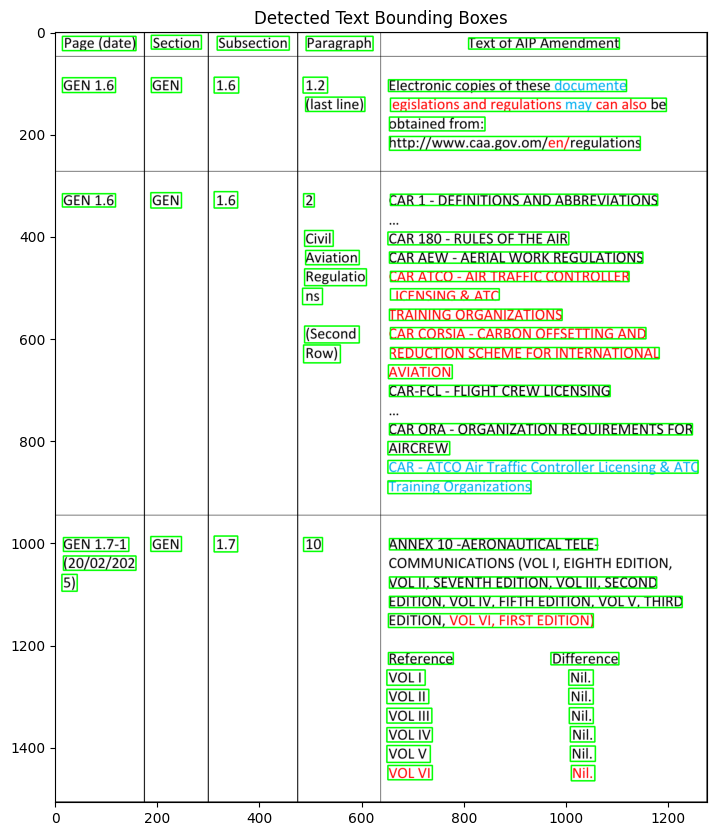

In [8]:
import matplotlib.pyplot as plt

# Copy the original table image
image_with_boxes = table_region.copy()

# Draw bounding boxes on the image
for line in result[0]:
    [[x1, y1, x2, y2], text, confidence] = line[0], line[1][0], line[1][1]
    cv2.rectangle(image_with_boxes, (int(x1[0]), int(y1[1])), (int(x2[0]), int(y2[1])), (0, 255, 0), 2)  # Green box

# Show the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Detected Text Bounding Boxes")
plt.show()

In [9]:
# Install PaddleOCR & Dependencies
!pip install "paddlepaddle" "paddleocr" "pdf2image" "opencv-python" "pandas" "numpy"
!apt-get install -y poppler-utils  # Required for pdf2image

import cv2
import numpy as np
import pandas as pd
from paddleocr import PaddleOCR
from pdf2image import convert_from_path
from PIL import Image
import os
import collections
import matplotlib.pyplot as plt
from google.colab import files

# Step 1: Upload PDF Manually in Colab
uploaded = files.upload()  # Manually upload the PDF
pdf_file = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_file}")

output_csv_path = "/content/extracted_table.csv"  # Colab working directory

# Step 2: Convert PDF Page 2 to Image (Keep in COLOR)
images = convert_from_path(pdf_file, first_page=2, last_page=2)
image_path = "/content/page_2.png"
images[0].save(image_path, "PNG")

# Step 3: Load Image WITHOUT Grayscale
image = cv2.imread(image_path)  # Read in color (BGR)

# Step 4: Detect Table Structure using OpenCV
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for thresholding
thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours & filter for the table
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
table_boxes = [cv2.boundingRect(c) for c in contours if cv2.boundingRect(c)[2] > 400 and cv2.boundingRect(c)[3] > 100]

# Select the largest detected table
table_boxes = sorted(table_boxes, key=lambda b: b[2] * b[3], reverse=True)
if len(table_boxes) > 0:
    x, y, w, h = table_boxes[0]  # Largest detected table
    table_region = image[y:y+h, x:x+w]  # Keep in COLOR
    cropped_table_path = "/content/cropped_table.png"
    cv2.imwrite(cropped_table_path, table_region)  # Save cropped table image

# Step 5: Extract Text from Only the Table Using PaddleOCR (Keep Color)
ocr = PaddleOCR(use_angle_cls=True, lang="en")  # Use lightweight PaddleOCR instead of PP-Structure
result = ocr.ocr(cropped_table_path, cls=True)

# Step 6: Improved Color Detection
def get_text_color(image, x1, y1, x2, y2):
    """Determines the dominant text color in a bounding box using thresholding & masking."""
    roi = image[max(0, y1):min(y2, image.shape[0]), max(0, x1):min(x2, image.shape[1])]  # Crop text area

    # Convert to grayscale & apply thresholding to isolate text
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_roi, 200, 255, cv2.THRESH_BINARY_INV)  # Invert to get text pixels

    # Apply bitwise mask to extract text-colored pixels only
    text_pixels = cv2.bitwise_and(roi, roi, mask=binary_mask)

    # Reshape and remove zero pixels (background)
    nonzero_pixels = text_pixels.reshape(-1, 3)
    nonzero_pixels = nonzero_pixels[(nonzero_pixels[:, 0] > 0) | (nonzero_pixels[:, 1] > 0) | (nonzero_pixels[:, 2] > 0)]

    if len(nonzero_pixels) == 0:
        return "unknown"  # No text detected

    # Get most frequent color among text pixels
    counter = collections.Counter([tuple(p) for p in nonzero_pixels])
    dominant_color = max(counter, key=counter.get)  # Most frequent color

    r, g, b = dominant_color[2], dominant_color[1], dominant_color[0]  # Convert BGR to RGB

    # Debugging: Print color values
    print(f"Detected color (R,G,B): ({r:.0f}, {g:.0f}, {b:.0f}) at [{x1}, {y1}, {x2}, {y2}]")

    # Define new color thresholds (tuned for OCR text colors)
    if r > 120 and g < 100 and b < 100:
        return "red"
    elif b > 120 and r < 100 and g < 100:
        return "blue"
    elif r > 50 and g > 50 and b > 50:
        return "black"
    else:
        return "unknown"

# Extract Text & Color Information
table_data = []
for line in result[0]:
    [[x1, y1, x2, y2], text, confidence] = line[0], line[1][0], line[1][1]
    text_color = get_text_color(table_region, int(x1[0]), int(y1[1]), int(x2[0]), int(y2[1]))
    table_data.append([text, x1[0], y1[1], x2[0], y2[1], confidence, text_color])  # Extract text & color

# Step 7: Improved Sorting & Column Assignment
table_data = sorted(table_data, key=lambda b: (b[2], b[1]))  # Sort top to bottom, left to right

num_cols = 7  # Define expected number of columns (added 2 new columns)
table_rows = []
current_row = [""] * num_cols  # Empty row template
prev_y = None
col_positions = sorted(set(x1 for _, x1, _, _, _, _, _ in table_data))[:5]  # Ensure only first 5 columns are used

# Assign Text to the Correct Column & Create New Columns
for text, bbox_x1, bbox_y1, bbox_x2, bbox_y2, conf, text_color in table_data:
    y1 = bbox_y1  # Y-position
    x1 = bbox_x1  # X-position

    # Find the closest column
    col_index = min(range(len(col_positions)), key=lambda i: abs(col_positions[i] - x1))

    # Merge Multi-Line Cells Correctly
    if prev_y is not None and abs(prev_y - y1) < 20:  # Small Y-difference → same row
        current_row[col_index] += " " + text
    else:
        # Store previous row before moving to new one
        if any(current_row):  # Only store non-empty rows
            table_rows.append(current_row)
        # Reset and start a new row
        current_row = [""] * num_cols
        current_row[col_index] = text

    # Assign Text to New Color-Based Columns (Only from Column 5)
    if col_index == 4:
        if text_color in ["black", "blue"]:  # Column 6: Black + Blue Text
            current_row[5] += " " + text
        if text_color in ["black", "red"]:  # Column 7: Black + Red Text
            current_row[6] += " " + text

    prev_y = y1  # Update previous y-coordinate

# Convert to DataFrame & Save
df = pd.DataFrame(table_rows, columns=["Page (date)", "Section", "Subsection", "Paragraph", "Text of AIP Amendment", "Black/Blue Text", "Black/Red Text"])
df.to_csv("/content/fixed_table_with_color.csv", index=False)

# Download CSV File
files.download("/content/fixed_table_with_color.csv")

print('✅ Table extraction with color filtering completed! Download the CSV file from Colab.')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Saving App-2 AIP DGCAR change request V1.3 (002).pdf to App-2 AIP DGCAR change request V1.3 (002) (5).pdf
Uploaded file: App-2 AIP DGCAR change request V1.3 (002) (5).pdf
[2025/03/04 14:32:12] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Table extraction with color filtering completed! Download the CSV file from Colab.
